# Gradio, VDSR, EDSR, ESPCN
In this notebook we try out 3 pretrained models for super resolution: VDSR, EDSR, ESPCN. They come with a package called `torch-enhance`. We also build a Gradio app for the demonstration.

In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch_enhance
from torch.utils.data import Dataset 
from torchvision import transforms

In [2]:
transform_div2k_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

transform_div2k_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [3]:
class ImageDatasetDIV2K(Dataset):
    def __init__(self, root_dir):
        super(ImageDatasetDIV2K, self).__init__()
        self.data = []
        self.root_dir = root_dir
        files_low = os.listdir(os.path.join(root_dir, "Compressed_X4"))
        files_high = os.listdir(os.path.join(root_dir, "X4"))
        self.data = list(zip(files_low, files_high))
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_low_file, img_high_file = self.data[index]
        
        low_res_pth = os.path.join(self.root_dir, "Compressed_X4", img_low_file)
        high_res_pth = os.path.join(self.root_dir, "X4", img_high_file)

        low_res = np.array(Image.open(low_res_pth))
        high_res = np.array(Image.open(high_res_pth))
        
        low_res = low_res[:, :, :3]
        high_res = high_res[:, :, :3]
        
        low_res = transform_div2k_low(low_res)
        high_res = transform_div2k_high(high_res)
        
        return low_res, high_res

In [4]:
data = ImageDatasetDIV2K(root_dir='./DIV2K_valid_LR_bicubic/')
data[0]

(tensor([[[0.4980, 0.2588, 0.2824,  ..., 0.3922, 0.3882, 0.3373],
          [0.2745, 0.2039, 0.2863,  ..., 0.3373, 0.4392, 0.3176],
          [0.2902, 0.2549, 0.2745,  ..., 0.3686, 0.5490, 0.2824],
          ...,
          [0.5569, 0.5216, 0.3961,  ..., 0.1922, 0.1882, 0.1843],
          [0.5373, 0.5451, 0.4627,  ..., 0.2118, 0.1608, 0.1765],
          [0.5569, 0.5961, 0.4784,  ..., 0.1765, 0.1608, 0.1529]],
 
         [[0.4980, 0.2588, 0.2824,  ..., 0.3922, 0.3882, 0.3373],
          [0.2745, 0.2039, 0.2863,  ..., 0.3373, 0.4392, 0.3176],
          [0.2902, 0.2549, 0.2745,  ..., 0.3686, 0.5490, 0.2824],
          ...,
          [0.5569, 0.5216, 0.3961,  ..., 0.1922, 0.1882, 0.1843],
          [0.5373, 0.5451, 0.4627,  ..., 0.2157, 0.1647, 0.1804],
          [0.5569, 0.5961, 0.4784,  ..., 0.1922, 0.1725, 0.1647]],
 
         [[0.4980, 0.2588, 0.2824,  ..., 0.3922, 0.3882, 0.3373],
          [0.2745, 0.2039, 0.2863,  ..., 0.3373, 0.4392, 0.3176],
          [0.2902, 0.2549, 0.2745,  ...,

In [5]:
model_vdsr = torch_enhance.models.VDSR(scale_factor=2, channels=3)
mse_loss = torch.nn.MSELoss()

import torch.nn.functional as F

def psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    psnr_value = 20 * torch.log10(1 / torch.sqrt(mse))
    return psnr_value.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
MSE: 0.002532696584239602, PSNR: 25.964168548583984


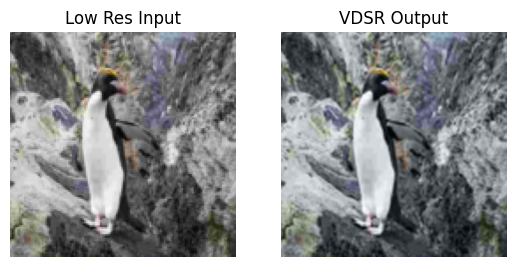

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
MSE: 0.002607457572594285, PSNR: 25.837825775146484


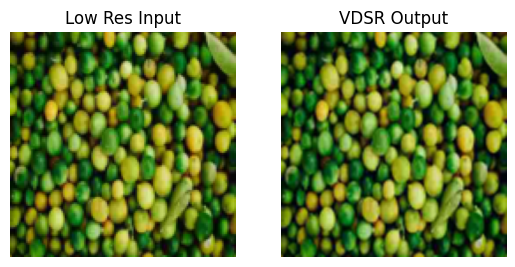

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
MSE: 0.002380721503868699, PSNR: 26.232913970947266


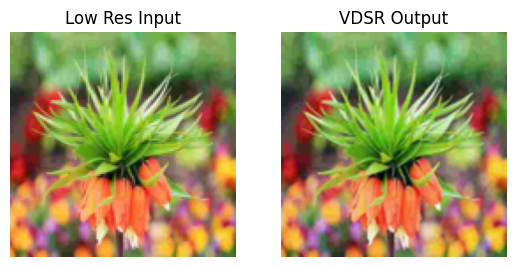

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
MSE: 0.004121686797589064, PSNR: 23.84925079345703


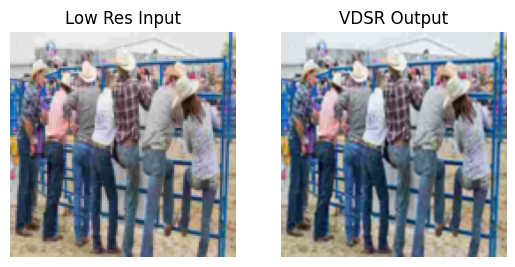

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
MSE: 0.0018195615848526359, PSNR: 27.400331497192383


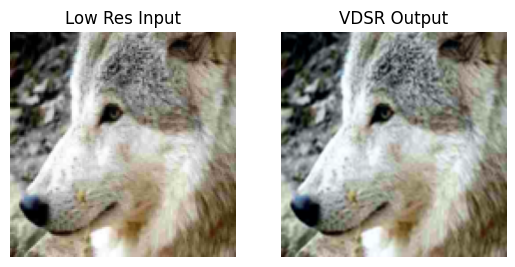

In [6]:
import matplotlib.pyplot as plt

for i in range(5):
    low_res = data[i][0]
    high_res = data[i][1]

    with torch.no_grad():
        output = model_vdsr(low_res.unsqueeze(0))

    output = output.squeeze(0)
    print(output.shape)
    print(high_res.shape)

    mse_val = mse_loss(high_res, output)
    psnr_val = psnr(high_res, output)

    low_res = low_res.permute(1, 2, 0).cpu().numpy()
    high_res = high_res.permute(1, 2, 0).cpu().numpy()
    output = output.permute(1, 2, 0).cpu().numpy()

    print(f'MSE: {mse_val}, PSNR: {psnr_val}')

    plt.subplot(1, 2, 1)
    plt.imshow(low_res)
    plt.axis('off')  
    plt.title('Low Res Input')

    plt.subplot(1, 2, 2)
    plt.imshow(output)
    plt.axis('off')
    plt.title('VDSR Output')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
MSE: 0.30279383063316345, PSNR: 5.188529968261719


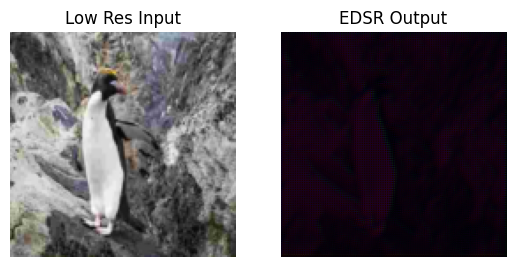

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
MSE: 0.16316138207912445, PSNR: 7.873826026916504


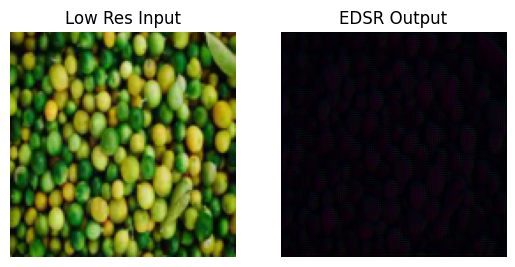

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
MSE: 0.31398525834083557, PSNR: 5.030908107757568


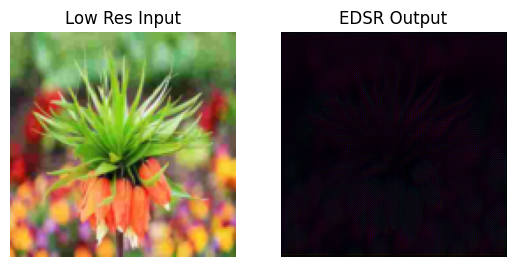

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
MSE: 0.37716007232666016, PSNR: 4.234742641448975


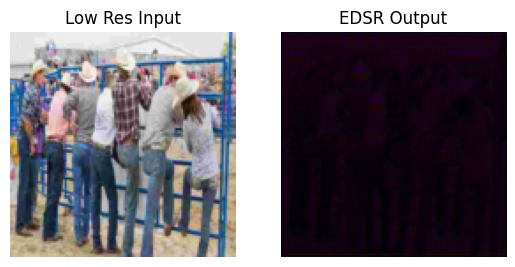

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
MSE: 0.4030647277832031, PSNR: 3.94625186920166


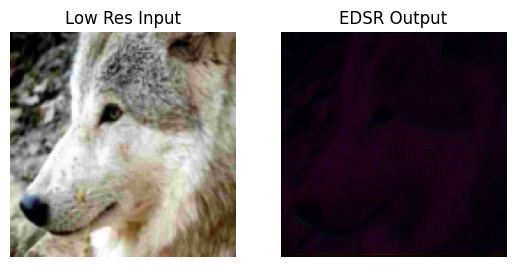

In [7]:
model_edsr = torch_enhance.models.EDSR(scale_factor=2, channels=3)

for i in range(5):
    low_res = data[i][0]
    high_res = data[i][1]

    with torch.no_grad():
        output = model_edsr(low_res.unsqueeze(0))

    output = output.squeeze(0)
    print(output.shape)
    print(high_res.shape)

    mse_val = mse_loss(high_res, output)
    psnr_val = psnr(high_res, output)

    low_res = low_res.permute(1, 2, 0).cpu().numpy()
    high_res = high_res.permute(1, 2, 0).cpu().numpy()
    output = output.permute(1, 2, 0).cpu().numpy()

    print(f'MSE: {mse_val}, PSNR: {psnr_val}')

    plt.subplot(1, 2, 1)
    plt.imshow(low_res)
    plt.axis('off')  
    plt.title('Low Res Input')

    plt.subplot(1, 2, 2)
    plt.imshow(output)
    plt.axis('off')
    plt.title('EDSR Output')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
MSE: 0.28564968705177307, PSNR: 5.4416632652282715


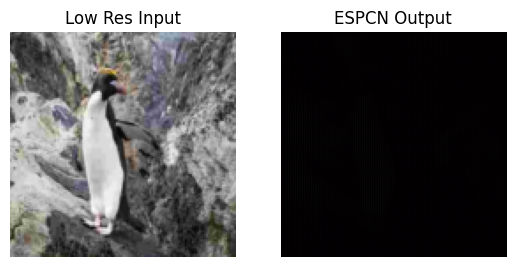

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
MSE: 0.15068142116069794, PSNR: 8.219403266906738


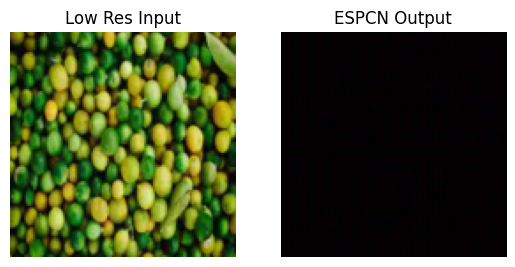

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
MSE: 0.2922494411468506, PSNR: 5.342463493347168


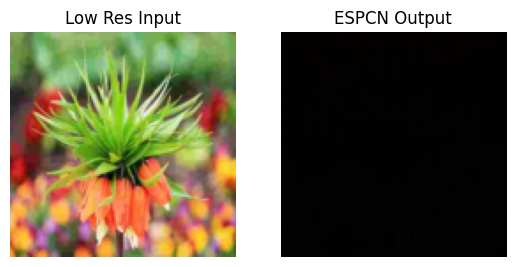

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
MSE: 0.3571319282054901, PSNR: 4.471713066101074


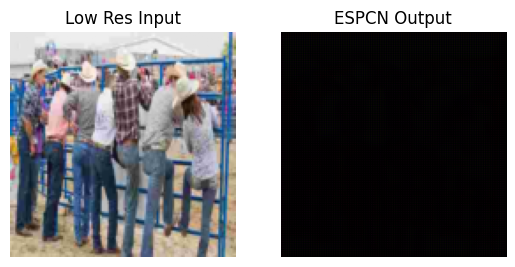

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
MSE: 0.3774357736110687, PSNR: 4.231569766998291


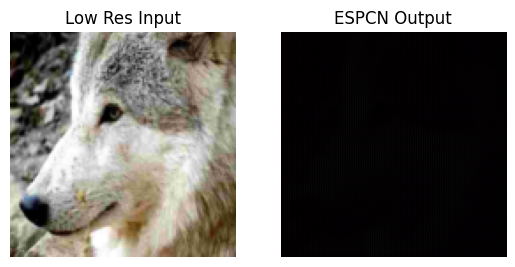

In [8]:
model_ESPCN = torch_enhance.models.ESPCN(scale_factor=2, channels=3)

for i in range(5):
    low_res = data[i][0]
    high_res = data[i][1]

    with torch.no_grad():
        output = model_ESPCN(low_res.unsqueeze(0))

    output = output.squeeze(0)
    print(output.shape)
    print(high_res.shape)

    mse_val = mse_loss(high_res, output)
    psnr_val = psnr(high_res, output)

    low_res = low_res.permute(1, 2, 0).cpu().numpy()
    high_res = high_res.permute(1, 2, 0).cpu().numpy()
    output = output.permute(1, 2, 0).cpu().numpy()

    print(f'MSE: {mse_val}, PSNR: {psnr_val}')

    plt.subplot(1, 2, 1)
    plt.imshow(low_res)
    plt.axis('off')  
    plt.title('Low Res Input')

    plt.subplot(1, 2, 2)
    plt.imshow(output)
    plt.axis('off')
    plt.title('ESPCN Output')

    plt.show()

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [19]:
def super_resolution(input_image):
    # Preprocess the input image
    inp = transforms.ToTensor()(input_image).unsqueeze(0)

    # Perform super-resolution using the SRCNN model
    with torch.no_grad():
        output_tensor = model_vdsr(inp)

    # Convert the output tensor to a NumPy array
    output_image = output_tensor.squeeze(0).permute(1, 2, 0).numpy()

    # Denormalize the output image
    output_image = (output_image + 1) / 2.0

    return output_image

In [20]:
import gradio as gr
iface = gr.Interface(fn=super_resolution, inputs=gr.Image(type='pil'), outputs="image")

# Launch the Gradio interface
iface.launch()

Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gradio\queueing.py", line 495, in call_prediction
    output = await route_utils.call_process_api(
  File "C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gradio\route_utils.py", line 232, in call_process_api
    output = await app.get_blocks().process_api(
  File "C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gradio\blocks.py", line 1570, in process_api
    data = self.postprocess_data(fn_index, result["prediction"], state)
  File "C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gradio\blocks.py", line 1455, in postprocess_data
    pred